# Data Augmentation
Boost performance by creating extra training data.

# 📚 Data Augmentation for Image Classification

Data augmentation improves image classifiers by generating **new training examples** through transformations like flipping or changing contrast, **without altering the labels**. It helps the model **generalize better** to new data by teaching it to ignore irrelevant variations.  
⚡ **Important**: Always use transformations that **preserve the class** (e.g., don't rotate handwritten digits like '6' and '9').



In [2]:
from tensorflow import keras
from tensorflow.keras import layers

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'c:/Users/samad/OneDrive/Dokumenty/526546846848/Computer_Vision/car-or-truck/versions/1/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'c:/Users/samad/OneDrive/Dokumenty/526546846848/Computer_Vision/car-or-truck/versions/1/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


# Explore Augmentation #


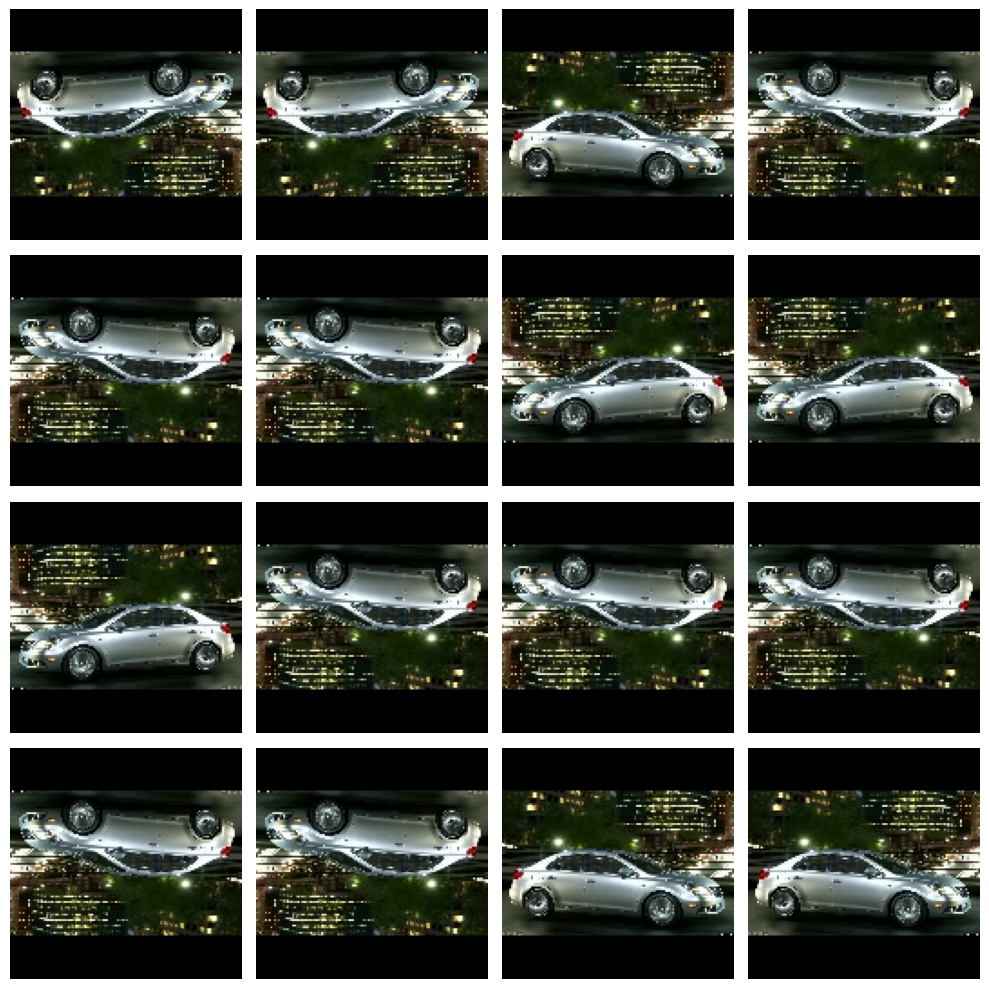

In [9]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
    # preprocessing.RandomContrast(factor=0.5),
    layers.RandomFlip(mode='horizontal'), # meaning, left-to-right
    layers.RandomFlip(mode='vertical'), # meaning, top-to-bottom
    # layers.RandomWidth(factor=0.15), # horizontal stretch
    # layers.RandomRotation(factor=0.20),
    # layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

# Add Preprocessing Layers #


In [19]:
model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    layers.RandomContrast(factor=0.10),
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.10),
    
    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 351s 4s/step - binary_accuracy: 0.5770 - loss: 0.6717 - val_binary_accuracy: 0.5785 - val_loss: 0.7014
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 521s 7s/step - binary_accuracy: 0.6787 - loss: 0.5986 - val_binary_accuracy: 0.5785 - val_loss: 0.7910
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 334s 4s/step - binary_accuracy: 0.7221 - loss: 0.5516 - val_binary_accuracy: 0.5785 - val_loss: 0.9821
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 333s 4s/step - binary_accuracy: 0.7549 - loss: 0.4980 - val_binary_accuracy: 0.5789 - val_loss: 0.9217
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - binary_accuracy: 0.7986 - loss: 0.4364 - val_binary_accuracy: 0.5902 - val_loss: 0.8432
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 469s 6s/step - binary_accuracy: 0.8200 - loss: 0.3893 - val_binary_accuracy: 0.7177 - val_loss: 0.5677
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 467s 6s/step - binary_accuracy: 0.8375 - loss: 0.3537 - val_binary_accuracy: 0.7408 - val_loss: 0.5824
Epoch 8/50
80

<Axes: >

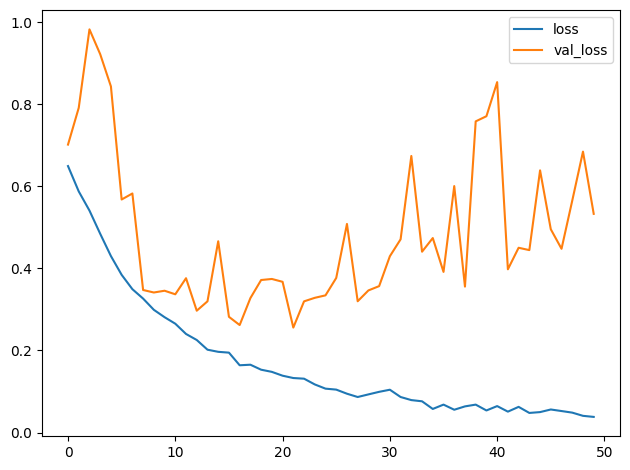

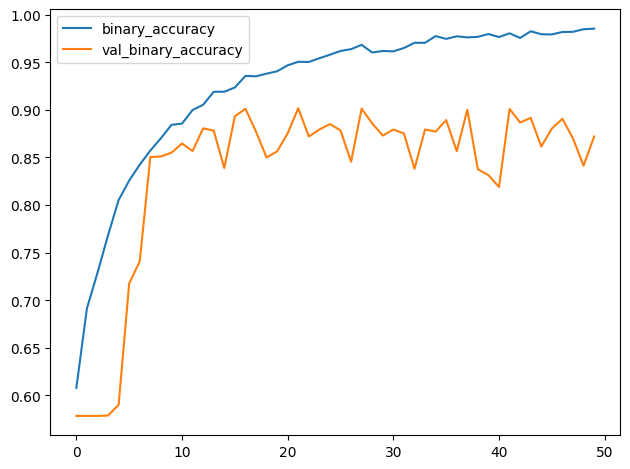

In [20]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

# 4) Train Model #

Examine the training curves. What there any sign of overfitting? How does the performance of this model compare to other models you've trained in this course?